Analyse sensitivity experiments with neXtSIM comparing diffrent settings of Pmax and Clab respectively. 

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook

import numpy as np
import datetime as dt
import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb
from pynextsim.projection_info import ProjectionInfo
import os 
import sys
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
from netCDF4 import Dataset

In [2]:
# get cs2smos variables on neXtSIM mesh elements

# date to plot
dto = dt.datetime(2013,2,1,6,0)

obs_inpath = '/cluster/projects/nn2993k/sim/data/CS2_SMOS_v2.0/'
fl_obs = obs_inpath + 'awi-cs2smos-l4-sithick-cryosat2_smos_merged-rep-nh25km_ease2-20130128_20130203-fv2p0.nc'

# Fix - variable names to be consistent with nc file  
o = pnops.OpenerCs2SmosThick()
o.variables['Thickness'].name = 'analysis_ice_thickness'
o.variables['Thickness_Uncertainty'].name = 'analysis_thickness_unc'
o.variables['Concentration'].name = 'ice_conc'

# get grid info (bounding box, lat/lon) from model (i.e. small_arctic_10km)
moorings = NetcdfList(['/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/1/Moorings_2013m02.nc'])
bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)
lon, lat = moorings.file_objects[0].get_lonlat() 

nci_obs = mnu.nc_getinfo(fl_obs)
obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
obs_vars = obs_grid.get_external_data(
                o.variables,
                dto,
                nci=nci_obs,
                data_on_same_grid=True, #we always use the obs grid
                allow_missing=True)

# grid to interpolate to
xy_mod = obs_grid.projection.pyproj(lon, lat)


reduce grid bbox:  [-2584859.0247218814, 2714189.166638696, -2151842.919231681, 3139273.504268901]
Variable:  analysis_ice_thickness
Reading external data (on same grid)
Variable:  analysis_thickness_unc
Reading external data (on same grid)
Variable:  ice_conc
Reading external data (on same grid)


In [3]:
# open Morrings from Nextsim output

rootdir = '/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/'

# create lists containing Pmax and Clab values 
pmax = [3,5,7]
clab = [1.5, 3, 4.5]

XY=np.meshgrid(pmax,clab)

mat = np.array(XY).transpose()
# Transpose will transform your (2,num_y,num_x) array into
# the desired (num_x,num_y,2) array.

nexp= len(pmax)*len(clab)

path = sorted(os.listdir(rootdir))    # sorted by number
filename='Moorings_2013m02.nc'

# prepare outout
nsiti = np.zeros((nexp, len(obs_grid.xy[0]), len(obs_grid.xy[1])))
nsici =np.zeros((nexp, len(obs_grid.xy[0]), len(obs_grid.xy[1])))

print(nsiti.shape)

# loop over directories
n=0
for dirs in path:
    fl=os.path.join(rootdir, dirs, filename)
    print(fl)
    opener_moorings = pnops.OpenerNextsimMoorings(rootdir+dirs)
    data = NetcdfList([fl])

    # get Nextsim ice thickness and conc
    nsit = data.get_var(dto, 'Thickness')
    nsic =  data.get_var(dto, 'Concentration') 
    nhfs =  data.get_var(dto, 'hfs')
    
    # Interpolate model grid to observational grid 
    irreg_grid_interp = IrregularGridInterpolator(*xy_mod, *obs_grid.xy)
    print('Interpolation done')

    # get model data on observational grid
    nsiti[n,:,:] = irreg_grid_interp.interp_field(nsit)
    nsici[n,:,:] = irreg_grid_interp.interp_field(nsic)
    
    n+=1
    
    # for each exp get moorings file and open with openers for a specific date
    # then get cs2smos variables on neXtSIM mesh elements 
    # next interpolate Moorings to observational grid (write a function)
    # then calculate anomaly and save in matrix/dictionary or plot directly in subplot
    # alternatively save to matrix and plot when loop is done 

(9, 212, 212)
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/1/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/2/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/3/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/4/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/5/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/6/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/7/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/8/Moorings_2013m02.nc
Interpolation done
/cluster/work/users/rheinlender/breakup2013/pmax_clab_exp/outputs/9/Moorings_2013m02.nc
Interpolation done


In [4]:
def inset_colorbar(fig, ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    axins = inset_axes(ax,
                       width="3%",  # width = 50% of parent_bbox width
                       height="50%",  # height : 5%
                       loc='upper right',
                       #bbox_to_anchor=(1.05, 0., 1, 1),
                       #bbox_transform=ax.transAxes,
                       borderpad=2.5,
                       )

    cbar = fig.colorbar(mappable, cax=axins, orientation="vertical", **kwargs)
    
    # Controlling the placement of the inset axes is basically same as that
    # of the legend.  you may want to play with the borderpad value and
    # the bbox_to_anchor coordinate.
    return cbar

<IPython.core.display.Javascript object>


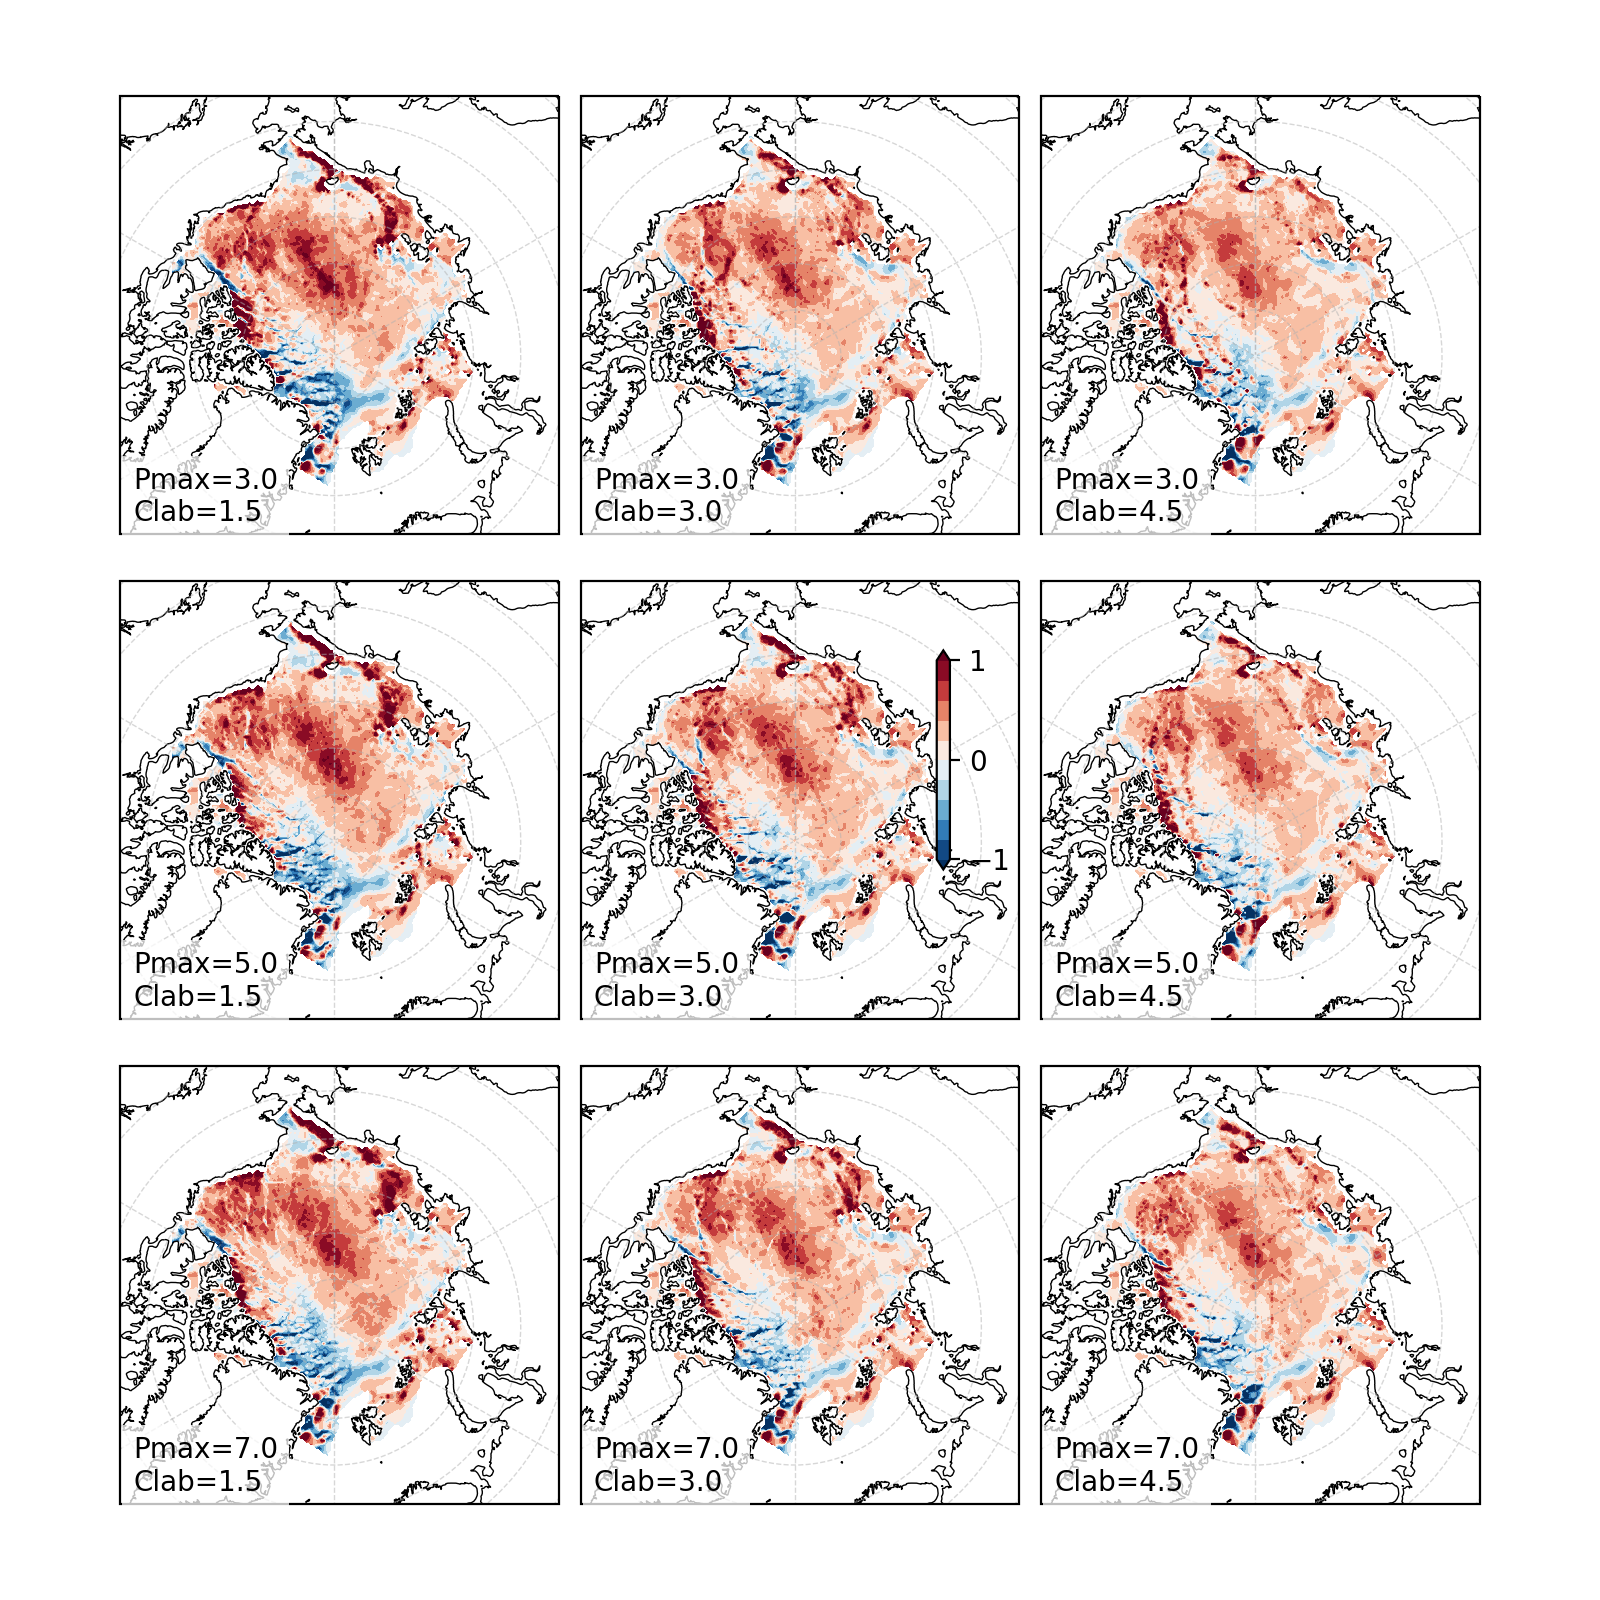

Pmax=3.0
Clab=1.5 0
Pmax=3.0
Clab=3.0 1
Pmax=3.0
Clab=4.5 2
Pmax=5.0
Clab=1.5 3
Pmax=5.0
Clab=3.0 4
Pmax=5.0
Clab=4.5 5
Pmax=7.0
Clab=1.5 6
Pmax=7.0
Clab=3.0 7
Pmax=7.0
Clab=4.5 8


In [5]:
# get projection info from model
mproj = pyproj.Proj(moorings.file_objects[0].proj_info.proj4_string)

# make discrete colormap
levs = np.arange(-1, 1.+0.2, 0.2)
extent = [0, 180, 57, 90]

ar = 1.0  # initial aspect ratio for first trial
wi = 8    # width in inches
hi = wi * ar  # height in inches

fig = plt.figure(figsize=(wi,hi))

plt.subplots_adjust(hspace=0.03, wspace=0.05, top=0.95, bottom=0.05, left=0.075, right=0.925)

gs = gridspec.GridSpec(3,3)

# loop over all experiments
reshaped_mat = mat.reshape(9,2)
i=0 # counter
for val in reshaped_mat:
    tmp=nsiti[i,:,:]
    ax = plt.subplot(gs[i], projection=ccrs.NorthPolarStereo(central_longitude=0), extent=extent)

    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
    ax.set_extent(bbox, crs=ccrs.NorthPolarStereo())

    c = ax.contourf(tmp-obs_vars['Thickness'], origin='upper', extent=bbox,
                   transform=ccrs.NorthPolarStereo(),levels=levs, cmap='RdBu_r', extend='both')

    # add title inside subplots
    lst = ['Pmax='+str(val[0]), 'Clab='+str(val[1])]
    lst = '\n'.join(lst)

    ax.text(0.03,0.03,lst,
            horizontalalignment='left',
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))

    print(lst, i)
    i+=1

    
    if i==5:
        # put colorbar bottom of center subplot 
        cb=inset_colorbar(fig,ax,c)  
        cb.set_ticks([-1,0,1])
     
    
# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/plots/pmax_clab_exp/'
figname = outpath_plots+'sit_anom_20130101_'+ 'nextsim.r10.era5.pmax_clab_exp.png'
fig.savefig(figname, dpi=150, bbox_inches='tight')